<a href="https://colab.research.google.com/github/ZiedHY/Image-classification---Fashion-MNIST/blob/master/Image_classification_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [3]:
from google.colab import files

uploaded = files.upload()

Saving fashion-mnist_train.csv to fashion-mnist_train (1).csv
Saving fashion-mnist_test.csv to fashion-mnist_test (1).csv


In [0]:
data_train = pd.read_csv("fashion-mnist_train.csv")
data_test = pd.read_csv("fashion-mnist_test.csv")

In [0]:
img_rows, img_cols = 28, 28
# The 3rd dimension is the pixel-value in a grayscale (an integer between 0 and 255)
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))


# Reshaping input data 
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

# Standardizing input data 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils.training_utils import multi_gpu_model
import argparse


In [0]:
# Initialization of CNNs' parameters 
# Using batches to compute the gradient on a subset of data (mini-bach) and use it as an estimate of the true gradient
batch_size = 256 # 16*16 batches
num_classes = 10 # number of output classes
epochs = 50 # Number of iterations to train the model 

#input image dimensions
img_rows, img_cols = 28, 28

# Parameter for Image Data Augumentation
shift_fraction=0.005

In [0]:
# Building the architecture 
model = Sequential()
# 32 3*3 filters (feature maps) applied on (28,28,1) images  
# ReLU  activation function to introduce non-linearity 
# kernel_initializer gives kernel weights. Here we use 'he_normal' which draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor (9 in this case)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape)) 
# Now: model.output_shape == (None, 26, 26, 32) 

# Pooling to reduce dimensionality and preserve spatial invariance
# Max pool with 2*2 filters and stride 1 
model.add(MaxPooling2D((2, 2)))
# Now: model.output_shape == (None, 13, 13, 32) 

# Dropout: in each iteration, we randomly dropout 25% of the hidden neurals to avoid building too complex models that "memorize" data. The output shape is not affected.  
model.add(Dropout(0.25))

# Introducing a new layer following the same process described above 

# Here the output depth is 64 
model.add(Conv2D(64, (3, 3), activation='relu'))
# Now: model.output_shape == (None, 11, 11, 64) 

model.add(MaxPooling2D(pool_size=(2, 2)))
# Now: model.output_shape == (None, 5, 5, 64) 

model.add(Dropout(0.25))

# Introducing a new layer following the same process described above 

# Here the output depth is 128 and 40% of data from the previous layer is not used  
# Now: model.output_shape == (None, 3, 3, 128)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))

# Flatten() to flatten the input
# Now: model.output_shape == (None, 1152 = 3*3*128)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
# In the final layer, we use softmax transformation to have output values between 0 and 1 (probabilty of image belonging to a particular class)
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.6/dist-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input

In [0]:
# Compile the model 
# Cross entropy is used as a loss function 
# Adam to adapt the learning rate value for each iteration of the gradient (not consider it as a fixed number)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
#@title
model.summary()

In [0]:
# Training 
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.3354 - acc: 0.8787 - val_loss: 0.2909 - val_acc: 0.8909
Epoch 2/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.3211 - acc: 0.8815 - val_loss: 0.2839 - val_acc: 0.8953
Epoch 3/50
11264/48000 [======>.......................] - ETA: 1:43 - loss: 0.3206 - acc: 0.8819

48000/48000 [==============================] - 149s 3ms/step - loss: 0.3120 - acc: 0.8866 - val_loss: 0.2799 - val_acc: 0.8948
Epoch 4/50
48000/48000 [==============================] - 149s 3ms/step - loss: 0.2990 - acc: 0.8898 - val_loss: 0.2663 - val_acc: 0.9003
Epoch 5/50
32000/48000 [===================>..........] - ETA: 45s - loss: 0.2866 - acc: 0.8926

48000/48000 [==============================] - 149s 3ms/step - loss: 0.2877 - acc: 0.8931 - val_loss: 0.2609 - val_acc: 0.9026
Epoch 6/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.2836 - acc: 0.8952 - val_loss: 0.2552 - val_acc: 0.9048
Epoch 7/50
37120/48000 [======================>.......] - ETA: 30s - loss: 0.2745 - acc: 0.8984

48000/48000 [==============================] - 147s 3ms/step - loss: 0.2748 - acc: 0.8989 - val_loss: 0.2599 - val_acc: 0.9033
Epoch 8/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.2678 - acc: 0.9012 - val_loss: 0.2440 - val_acc: 0.9071
Epoch 9/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2646 - acc: 0.9040

48000/48000 [==============================] - 148s 3ms/step - loss: 0.2653 - acc: 0.9030 - val_loss: 0.2432 - val_acc: 0.9083
Epoch 10/50
48000/48000 [==============================] - 149s 3ms/step - loss: 0.2636 - acc: 0.9019 - val_loss: 0.2389 - val_acc: 0.9110
Epoch 11/50
38144/48000 [======================>.......] - ETA: 28s - loss: 0.2532 - acc: 0.9063

48000/48000 [==============================] - 148s 3ms/step - loss: 0.2536 - acc: 0.9070 - val_loss: 0.2352 - val_acc: 0.9125
Epoch 12/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.2515 - acc: 0.9078 - val_loss: 0.2365 - val_acc: 0.9125
Epoch 13/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2446 - acc: 0.9091

48000/48000 [==============================] - 147s 3ms/step - loss: 0.2466 - acc: 0.9083 - val_loss: 0.2309 - val_acc: 0.9132
Epoch 14/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.2420 - acc: 0.9095 - val_loss: 0.2307 - val_acc: 0.9136
Epoch 15/50
38144/48000 [======================>.......] - ETA: 28s - loss: 0.2394 - acc: 0.9112

48000/48000 [==============================] - 148s 3ms/step - loss: 0.2399 - acc: 0.9106 - val_loss: 0.2264 - val_acc: 0.9157
Epoch 16/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.2361 - acc: 0.9115 - val_loss: 0.2374 - val_acc: 0.9103
Epoch 17/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2298 - acc: 0.9137

48000/48000 [==============================] - 147s 3ms/step - loss: 0.2334 - acc: 0.9126 - val_loss: 0.2290 - val_acc: 0.9154
Epoch 18/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.2298 - acc: 0.9141 - val_loss: 0.2300 - val_acc: 0.9140
Epoch 19/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2261 - acc: 0.9159

48000/48000 [==============================] - 146s 3ms/step - loss: 0.2270 - acc: 0.9153 - val_loss: 0.2219 - val_acc: 0.9197
Epoch 20/50
48000/48000 [==============================] - 146s 3ms/step - loss: 0.2271 - acc: 0.9159 - val_loss: 0.2201 - val_acc: 0.9183
Epoch 21/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2220 - acc: 0.9187

48000/48000 [==============================] - 146s 3ms/step - loss: 0.2227 - acc: 0.9172 - val_loss: 0.2208 - val_acc: 0.9162
Epoch 22/50
48000/48000 [==============================] - 146s 3ms/step - loss: 0.2196 - acc: 0.9170 - val_loss: 0.2170 - val_acc: 0.9182
Epoch 23/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2108 - acc: 0.9216

48000/48000 [==============================] - 146s 3ms/step - loss: 0.2138 - acc: 0.9205 - val_loss: 0.2221 - val_acc: 0.9183
Epoch 24/50
48000/48000 [==============================] - 146s 3ms/step - loss: 0.2157 - acc: 0.9192 - val_loss: 0.2152 - val_acc: 0.9204
Epoch 25/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2118 - acc: 0.9204

48000/48000 [==============================] - 146s 3ms/step - loss: 0.2144 - acc: 0.9191 - val_loss: 0.2193 - val_acc: 0.9183
Epoch 26/50
48000/48000 [==============================] - 146s 3ms/step - loss: 0.2099 - acc: 0.9214 - val_loss: 0.2163 - val_acc: 0.9196
Epoch 27/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2072 - acc: 0.9223

48000/48000 [==============================] - 147s 3ms/step - loss: 0.2085 - acc: 0.9214 - val_loss: 0.2230 - val_acc: 0.9174
Epoch 28/50
48000/48000 [==============================] - 146s 3ms/step - loss: 0.2065 - acc: 0.9228 - val_loss: 0.2108 - val_acc: 0.9223
Epoch 29/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2026 - acc: 0.9239

48000/48000 [==============================] - 146s 3ms/step - loss: 0.2052 - acc: 0.9228 - val_loss: 0.2127 - val_acc: 0.9200
Epoch 30/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.2050 - acc: 0.9229 - val_loss: 0.2150 - val_acc: 0.9177
Epoch 31/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.2004 - acc: 0.9254

48000/48000 [==============================] - 147s 3ms/step - loss: 0.2034 - acc: 0.9244 - val_loss: 0.2119 - val_acc: 0.9221
Epoch 32/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.1983 - acc: 0.9243 - val_loss: 0.2186 - val_acc: 0.9188
Epoch 33/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.1971 - acc: 0.9269

48000/48000 [==============================] - 147s 3ms/step - loss: 0.1963 - acc: 0.9269 - val_loss: 0.2154 - val_acc: 0.9219
Epoch 34/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.1992 - acc: 0.9259 - val_loss: 0.2113 - val_acc: 0.9218
Epoch 35/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.1957 - acc: 0.9249

48000/48000 [==============================] - 146s 3ms/step - loss: 0.1959 - acc: 0.9254 - val_loss: 0.2200 - val_acc: 0.9197
Epoch 36/50
48000/48000 [==============================] - 147s 3ms/step - loss: 0.1954 - acc: 0.9268 - val_loss: 0.2109 - val_acc: 0.9215
Epoch 37/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.1907 - acc: 0.9279

48000/48000 [==============================] - 147s 3ms/step - loss: 0.1922 - acc: 0.9279 - val_loss: 0.2080 - val_acc: 0.9226
Epoch 38/50
48000/48000 [==============================] - 146s 3ms/step - loss: 0.1905 - acc: 0.9281 - val_loss: 0.2107 - val_acc: 0.9236
Epoch 39/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.1892 - acc: 0.9289

48000/48000 [==============================] - 148s 3ms/step - loss: 0.1923 - acc: 0.9277 - val_loss: 0.2185 - val_acc: 0.9224
Epoch 40/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.1904 - acc: 0.9284 - val_loss: 0.2078 - val_acc: 0.9248
Epoch 41/50
38144/48000 [======================>.......] - ETA: 27s - loss: 0.1902 - acc: 0.9286

48000/48000 [==============================] - 148s 3ms/step - loss: 0.1895 - acc: 0.9295 - val_loss: 0.2127 - val_acc: 0.9211
Epoch 42/50
48000/48000 [==============================] - 148s 3ms/step - loss: 0.1870 - acc: 0.9298 - val_loss: 0.2109 - val_acc: 0.9216
Epoch 43/50
38144/48000 [======================>.......] - ETA: 28s - loss: 0.1862 - acc: 0.9277

48000/48000 [==============================] - 148s 3ms/step - loss: 0.1880 - acc: 0.9272 - val_loss: 0.2167 - val_acc: 0.9217
Epoch 44/50
27648/48000 [================>.............] - ETA: 57s - loss: 0.1818 - acc: 0.9327

In [0]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2014412712007761
Test accuracy: 0.9256


In [0]:
gen = ImageDataGenerator(width_shift_range=shift_fraction,height_shift_range=shift_fraction,horizontal_flip=True)
batches = gen.flow(X_train, y_train, batch_size=batch_size)
val_batches = gen.flow(X_val, y_val, batch_size=batch_size)                       
                       

In [0]:
fashion_train=model.fit_generator(batches, steps_per_epoch=X_train.shape[0]//batch_size, epochs=epochs,validation_data=val_batches, validation_steps=X_val.shape[0]//batch_size, use_multiprocessing=True)

Epoch 1/50
187/187 [==============================] - 16s 87ms/step - loss: 0.3041 - acc: 0.8944 - val_loss: 0.2425 - val_acc: 0.9111
Epoch 2/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2530 - acc: 0.9083 - val_loss: 0.2339 - val_acc: 0.9142
Epoch 3/50
117/187 [=================>............] - ETA: 5s - loss: 0.2452 - acc: 0.9101

187/187 [==============================] - 17s 92ms/step - loss: 0.2448 - acc: 0.9103 - val_loss: 0.2269 - val_acc: 0.9162
Epoch 4/50
187/187 [==============================] - 17s 93ms/step - loss: 0.2427 - acc: 0.9114 - val_loss: 0.2308 - val_acc: 0.9129
Epoch 5/50
161/187 [========================>.....] - ETA: 2s - loss: 0.2366 - acc: 0.9123

187/187 [==============================] - 17s 93ms/step - loss: 0.2354 - acc: 0.9129 - val_loss: 0.2304 - val_acc: 0.9165
Epoch 6/50
187/187 [==============================] - 17s 93ms/step - loss: 0.2346 - acc: 0.9130 - val_loss: 0.2341 - val_acc: 0.9129
Epoch 7/50
170/187 [==========================>...] - ETA: 1s - loss: 0.2273 - acc: 0.9162

187/187 [==============================] - 17s 93ms/step - loss: 0.2278 - acc: 0.9163 - val_loss: 0.2313 - val_acc: 0.9150
Epoch 8/50
187/187 [==============================] - 17s 93ms/step - loss: 0.2264 - acc: 0.9166 - val_loss: 0.2193 - val_acc: 0.9197
Epoch 9/50
175/187 [===========================>..] - ETA: 0s - loss: 0.2241 - acc: 0.9144

187/187 [==============================] - 17s 93ms/step - loss: 0.2249 - acc: 0.9143 - val_loss: 0.2319 - val_acc: 0.9119
Epoch 10/50
187/187 [==============================] - 17s 92ms/step - loss: 0.2178 - acc: 0.9176 - val_loss: 0.2235 - val_acc: 0.9140
Epoch 11/50
175/187 [===========================>..] - ETA: 0s - loss: 0.2197 - acc: 0.9178

187/187 [==============================] - 17s 92ms/step - loss: 0.2197 - acc: 0.9181 - val_loss: 0.2231 - val_acc: 0.9180
Epoch 12/50
187/187 [==============================] - 17s 92ms/step - loss: 0.2179 - acc: 0.9181 - val_loss: 0.2153 - val_acc: 0.9197
Epoch 13/50
179/187 [===========================>..] - ETA: 0s - loss: 0.2164 - acc: 0.9188

187/187 [==============================] - 17s 92ms/step - loss: 0.2159 - acc: 0.9190 - val_loss: 0.2184 - val_acc: 0.9170
Epoch 14/50
187/187 [==============================] - 17s 92ms/step - loss: 0.2195 - acc: 0.9169 - val_loss: 0.2159 - val_acc: 0.9209
Epoch 15/50
180/187 [===========================>..] - ETA: 0s - loss: 0.2143 - acc: 0.9199

187/187 [==============================] - 17s 92ms/step - loss: 0.2140 - acc: 0.9200 - val_loss: 0.2156 - val_acc: 0.9189
Epoch 16/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2151 - acc: 0.9191 - val_loss: 0.2171 - val_acc: 0.9192
Epoch 17/50
181/187 [============================>.] - ETA: 0s - loss: 0.2162 - acc: 0.9189

187/187 [==============================] - 17s 91ms/step - loss: 0.2164 - acc: 0.9188 - val_loss: 0.2159 - val_acc: 0.9213
Epoch 18/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2153 - acc: 0.9195 - val_loss: 0.2141 - val_acc: 0.9201
Epoch 19/50
181/187 [============================>.] - ETA: 0s - loss: 0.2158 - acc: 0.9206

187/187 [==============================] - 17s 91ms/step - loss: 0.2157 - acc: 0.9204 - val_loss: 0.2149 - val_acc: 0.9197
Epoch 20/50
187/187 [==============================] - 17s 92ms/step - loss: 0.2146 - acc: 0.9202 - val_loss: 0.2173 - val_acc: 0.9198
Epoch 21/50
182/187 [============================>.] - ETA: 0s - loss: 0.2098 - acc: 0.9210

187/187 [==============================] - 17s 91ms/step - loss: 0.2101 - acc: 0.9211 - val_loss: 0.2175 - val_acc: 0.9219
Epoch 22/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2093 - acc: 0.9204 - val_loss: 0.2152 - val_acc: 0.9225
Epoch 23/50
181/187 [============================>.] - ETA: 0s - loss: 0.2064 - acc: 0.9215

187/187 [==============================] - 17s 91ms/step - loss: 0.2074 - acc: 0.9214 - val_loss: 0.2130 - val_acc: 0.9210
Epoch 24/50
187/187 [==============================] - 17s 92ms/step - loss: 0.2135 - acc: 0.9202 - val_loss: 0.2126 - val_acc: 0.9206
Epoch 25/50
179/187 [===========================>..] - ETA: 0s - loss: 0.2065 - acc: 0.9222

187/187 [==============================] - 17s 92ms/step - loss: 0.2061 - acc: 0.9226 - val_loss: 0.2119 - val_acc: 0.9204
Epoch 26/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2075 - acc: 0.9220 - val_loss: 0.2203 - val_acc: 0.9178
Epoch 27/50
182/187 [============================>.] - ETA: 0s - loss: 0.2025 - acc: 0.9234

187/187 [==============================] - 17s 92ms/step - loss: 0.2026 - acc: 0.9231 - val_loss: 0.2073 - val_acc: 0.9242
Epoch 28/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2073 - acc: 0.9219 - val_loss: 0.2130 - val_acc: 0.9209
Epoch 29/50
181/187 [============================>.] - ETA: 0s - loss: 0.2003 - acc: 0.9224

187/187 [==============================] - 17s 92ms/step - loss: 0.2007 - acc: 0.9223 - val_loss: 0.2147 - val_acc: 0.9213
Epoch 30/50
187/187 [==============================] - 17s 90ms/step - loss: 0.2060 - acc: 0.9239 - val_loss: 0.2093 - val_acc: 0.9221
Epoch 31/50
183/187 [============================>.] - ETA: 0s - loss: 0.2016 - acc: 0.9245

187/187 [==============================] - 17s 92ms/step - loss: 0.2015 - acc: 0.9244 - val_loss: 0.2116 - val_acc: 0.9223
Epoch 32/50
187/187 [==============================] - 17s 91ms/step - loss: 0.2035 - acc: 0.9243 - val_loss: 0.2113 - val_acc: 0.9197
Epoch 33/50
182/187 [============================>.] - ETA: 0s - loss: 0.2023 - acc: 0.9239

187/187 [==============================] - 17s 93ms/step - loss: 0.2025 - acc: 0.9238 - val_loss: 0.2123 - val_acc: 0.9206
Epoch 34/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1998 - acc: 0.9247 - val_loss: 0.2123 - val_acc: 0.9234
Epoch 35/50
183/187 [============================>.] - ETA: 0s - loss: 0.2036 - acc: 0.9235

187/187 [==============================] - 17s 92ms/step - loss: 0.2044 - acc: 0.9233 - val_loss: 0.2101 - val_acc: 0.9215
Epoch 36/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1993 - acc: 0.9252 - val_loss: 0.2196 - val_acc: 0.9200
Epoch 37/50
182/187 [============================>.] - ETA: 0s - loss: 0.2008 - acc: 0.9238

187/187 [==============================] - 17s 92ms/step - loss: 0.2003 - acc: 0.9239 - val_loss: 0.2103 - val_acc: 0.9227
Epoch 38/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1965 - acc: 0.9257 - val_loss: 0.2094 - val_acc: 0.9248
Epoch 39/50
181/187 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9246

187/187 [==============================] - 17s 92ms/step - loss: 0.1996 - acc: 0.9242 - val_loss: 0.2097 - val_acc: 0.9211
Epoch 40/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1959 - acc: 0.9268 - val_loss: 0.2064 - val_acc: 0.9243
Epoch 41/50
183/187 [============================>.] - ETA: 0s - loss: 0.1992 - acc: 0.9265

187/187 [==============================] - 17s 92ms/step - loss: 0.1986 - acc: 0.9266 - val_loss: 0.2171 - val_acc: 0.9196
Epoch 42/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1967 - acc: 0.9259 - val_loss: 0.2131 - val_acc: 0.9217
Epoch 43/50
183/187 [============================>.] - ETA: 0s - loss: 0.1979 - acc: 0.9267

187/187 [==============================] - 17s 91ms/step - loss: 0.1985 - acc: 0.9265 - val_loss: 0.2077 - val_acc: 0.9227
Epoch 44/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1947 - acc: 0.9252 - val_loss: 0.2138 - val_acc: 0.9209
Epoch 45/50
183/187 [============================>.] - ETA: 0s - loss: 0.1919 - acc: 0.9276

187/187 [==============================] - 17s 92ms/step - loss: 0.1925 - acc: 0.9273 - val_loss: 0.2136 - val_acc: 0.9229
Epoch 46/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1943 - acc: 0.9262 - val_loss: 0.2141 - val_acc: 0.9226
Epoch 47/50
183/187 [============================>.] - ETA: 0s - loss: 0.1919 - acc: 0.9263

187/187 [==============================] - 17s 91ms/step - loss: 0.1924 - acc: 0.9262 - val_loss: 0.2078 - val_acc: 0.9240
Epoch 48/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1950 - acc: 0.9256 - val_loss: 0.2110 - val_acc: 0.9264
Epoch 49/50
183/187 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9265

187/187 [==============================] - 17s 91ms/step - loss: 0.1955 - acc: 0.9260 - val_loss: 0.2098 - val_acc: 0.9227
Epoch 50/50
187/187 [==============================] - 17s 92ms/step - loss: 0.1931 - acc: 0.9262 - val_loss: 0.2089 - val_acc: 0.9229


In [0]:
# Evaluate Model against test data and get the score
score = model.evaluate(X_test, y_test, verbose=0)
# Print Metrics
print (score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[0.19595017693936825, 0.9285]
Test loss: 0.19595017693936825
Test accuracy: 0.9285


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [0]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = [i for i in range(len(y_test)) if np.nonzero(y_test[i])[0][0] == predicted_classes[i]]


incorrect_indices = [i for i in range(len(y_test)) if np.nonzero(y_test[i])[0][0] != predicted_classes[i]]


Each training and test example is assigned to one of the following labels:
0 T-shirt/top 1 Trouser 2 Pullover 3 Dress 4 Coat 5 Sandal 6 Shirt 7 Sneaker 8 Bag 9 Ankle boot


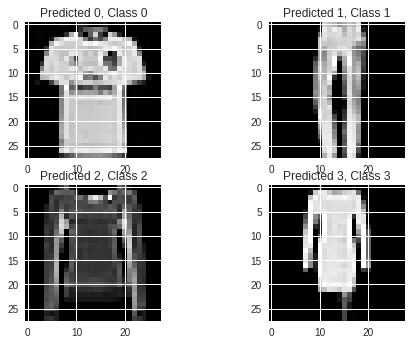

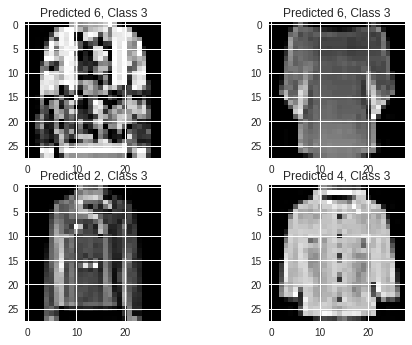

In [0]:
print("Each training and test example is assigned to one of the following labels:")
print("0 T-shirt/top","1 Trouser","2 Pullover","3 Dress","4 Coat","5 Sandal","6 Shirt","7 Sneaker","8 Bag","9 Ankle boot")
plt.figure()
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], np.nonzero(y_test[correct])[0][0]))
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], np.nonzero(y_test[correct])[0][0]))

In [0]:
data_train["label"].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [0]:
# Install Keras-MXNet v2.1.6 
!apt install libnvrtc8.0
!pip install mxnet-cu80
import mxnet as mx

Uninstalling mxnet-cu80-1.2.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/mxnet/*
    /usr/local/lib/python3.6/dist-packages/mxnet_cu80-1.2.0.dist-info/*
Proceed (y/n)? ^C
Operation cancelled by user


In [0]:
fashion_train=model.fit_generator(batches, steps_per_epoch=X_train.shape[0]//batch_size, epochs=epochs,validation_data=val_batches, validation_steps=X_val.shape[0]//batch_size, use_multiprocessing=True)